In [ ]:
# Import finance API and get historical stock data
#!pip install yfinance
#!pip install -U scikit-learn
import yfinance as yf
import os
import json
import pandas as pd


DATA_PATH = "msft_data.json"
msft = yf.Ticker("MSFT")
msft_hist = msft.history(period="max")

# Save file to json in case we need it later.  This prevents us from having to re-download it every time.
msft_hist.to_json(DATA_PATH)


In [ ]:
# Display microsoft stock price history so we can look at the structure of the data
msft_hist.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,0.055783,0.063987,0.055783,0.061252,1031788800,0.0,0.0
1986-03-14,0.061252,0.064533,0.061252,0.063439,308160000,0.0,0.0
1986-03-17,0.063439,0.065080,0.063439,0.064533,133171200,0.0,0.0
1986-03-18,0.064533,0.065080,0.062345,0.062892,67766400,0.0,0.0
1986-03-19,0.062892,0.063439,0.061252,0.061799,47894400,0.0,0.0


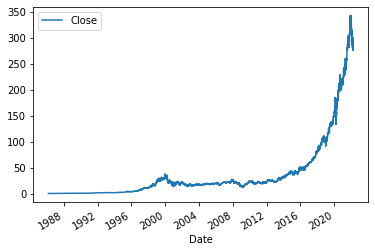

In [ ]:
# Visualize microsoft stock prices
msft_hist.plot.line(y="Close", use_index=True)

In [ ]:


# Ensure we know the actual closing price
data = msft_hist[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})

# Setup our target.  This identifies if the price went up or down
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]



In [ ]:


# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)



In [ ]:


# Create our training data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(msft_prev[predictors]).iloc[1:]

# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

In [ ]:
import keras.layers as kl
from keras.models import Model
from keras import regularizers
#define the LSTM neural network
input_data = kl.Input(shape=(1,train.shape[1]))
lstm = kl.LSTM(5, input_shape=(1,train.shape[1]), return_sequences=True, activity_regularizer=regularizers.l2(0.003),
                       recurrent_regularizer=regularizers.l2(0), dropout=0.2, recurrent_dropout=0.2)(input_data)
perc = kl.Dense(5, activation="sigmoid", activity_regularizer=regularizers.l2(0.005))(lstm)
lstm2 = kl.LSTM(2, activity_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.001),
                        dropout=0.2, recurrent_dropout=0.2)(perc)
out = kl.Dense(1, activation="sigmoid", activity_regularizer=regularizers.l2(0.001))(lstm2)
lstmNN=Model(input_data, out)
lstmNN._estimator_type = "classifier"

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
#define base models
level0 = []
level0.append(('rf', RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)))
level0.append(('lstm', lstmNN))
level0.append(('xgbc', XGBClassifier()))

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# define meta learner model
level1 = LogisticRegression()

# define the stacking ensemble
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
# fit the model on all available data
model.fit(train[predictors], train["Target"])

TypeError: ignored

In [ ]:


from sklearn.metrics import precision_score

# Evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)



0.5

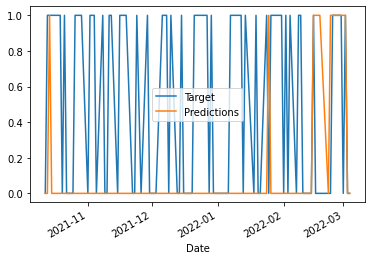

In [ ]:
combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()